In [1]:
from imutils.video import FileVideoStream
from imutils import face_utils
import numpy as np
import imutils
import dlib
import cv2
import time
import json
import matplotlib.pyplot as plt

In [2]:
# load file
FILE_NAME = "00485_Chinese_Asian_Female_Young/00485_1"
# define video path
VIDEOPATH = "video/" + FILE_NAME + ".mp4"
# define json path
JSONPATH = "video/" + FILE_NAME + ".json"
# use 68 key points face model
SHAPE_PREDICTOR = "model/shape_predictor_68_face_landmarks.dat"
# define lip region
(LIPFROM, LIPTO) = (49, 68)
# define threshold for lip motion
THRESHOLD = 0.65

In [3]:
# load json info
with open(JSONPATH,'r', encoding='utf-8') as load_f:
    load_dict = json.load(load_f)
# record speaking period
duration = []
for recored in load_dict:
    start = recored['start time']
    end = recored['end time']
    duration.append((start, end))
# print(duration)
# exit()

In [4]:
# define the face detector
DETECTOR = dlib.get_frontal_face_detector()
# define a shape predictor
PREDICTOR = dlib.shape_predictor(SHAPE_PREDICTOR)

In [5]:
# read original video
# fvs = FileVideoStream(path=VIDEOPATH).start()
VC = cv2.VideoCapture(VIDEOPATH)
# define output video
frame_width = int(VC.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(VC.get(cv2.CAP_PROP_FRAME_HEIGHT))
# out = cv2.VideoWriter('video/out_dlib.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 30, (frame_width,frame_height))

In [6]:
def lip_aspect_ratio(lip):

    # left top to left bottom
    A = np.linalg.norm(lip[2] - lip[9])  # 51, 59
    # right top to right bottom
    B = np.linalg.norm(lip[4] - lip[7])  # 53, 57
    # leftest to rightest
    C = np.linalg.norm(lip[0] - lip[6])  # 49, 55
    lar = (A + B) / (2.0 * C)

    return lar

In [7]:
def process_frame(frame):

    # preprocess
    frame = imutils.resize(frame, width=640)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    # detect face rect
    rects = DETECTOR(frame_gray, 0)

    Lars = []

    for rect in rects:
        # find key points inside the face rect
        shape = PREDICTOR(frame_gray, rect)
        shape = face_utils.shape_to_np(shape)

        # locate lip region
        lip = shape[LIPFROM:LIPTO]
        # get lip aspect ratio
        lar = lip_aspect_ratio(lip)
        Lars.append(lar)

        # get the shape of lip
        lip_shape = cv2.convexHull(lip)
        cv2.drawContours(frame, [lip_shape], -1, (0, 255, 0), 1)
        cv2.putText(frame, "LAR: {:.2f}".format(lar), (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 1)

        # if open
        if lar > THRESHOLD:
            cv2.putText(frame, "Mouth is Open!", (30, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 1)                

    return Lars, frame

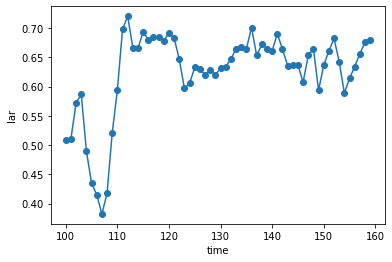

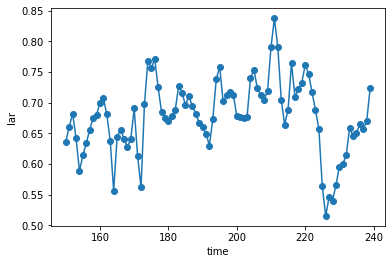

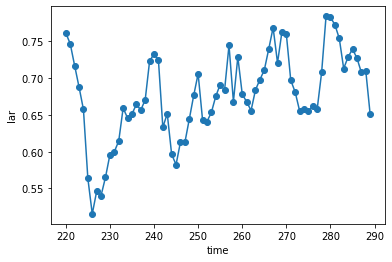

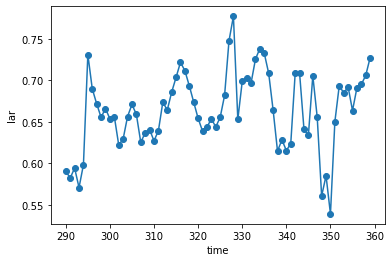

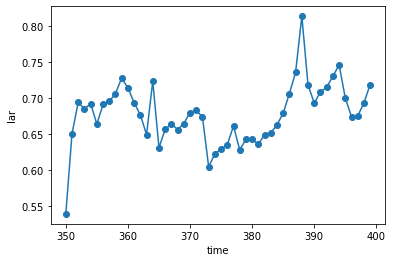

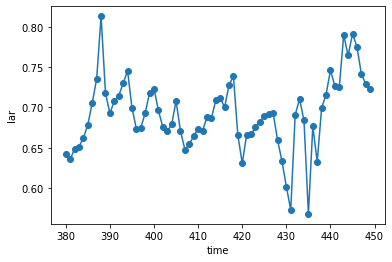

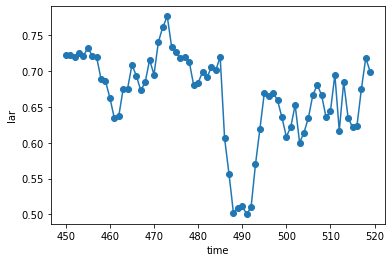

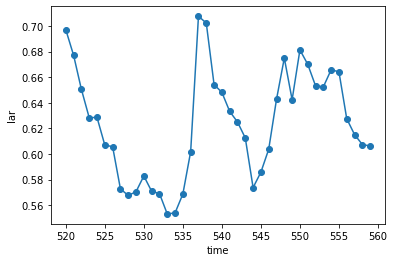

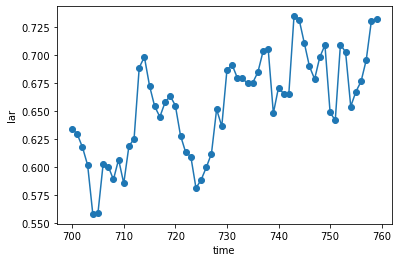

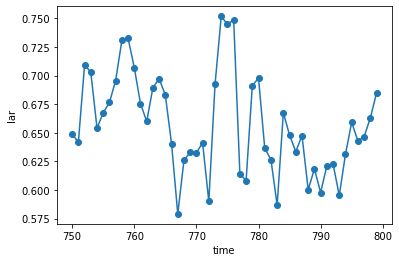

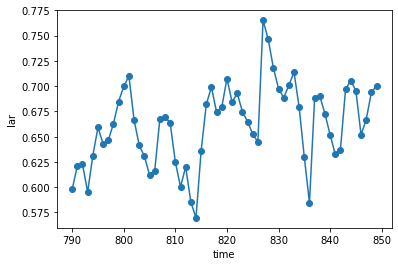

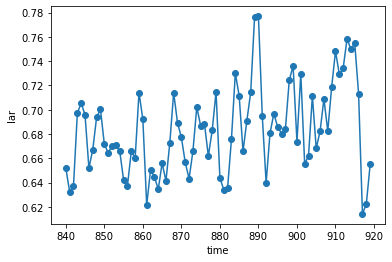

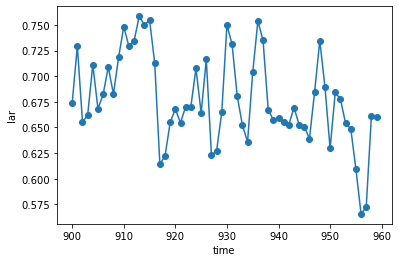

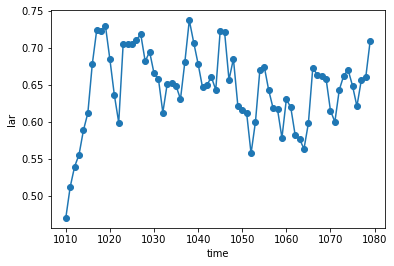

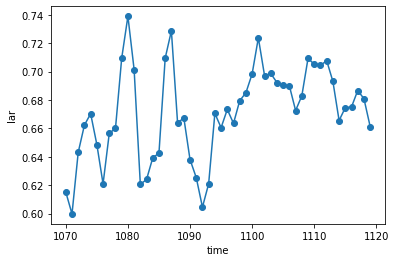

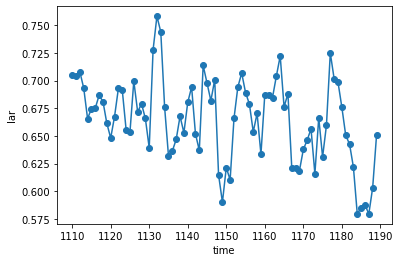

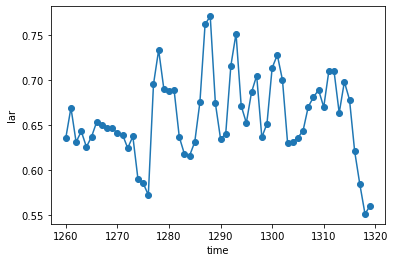

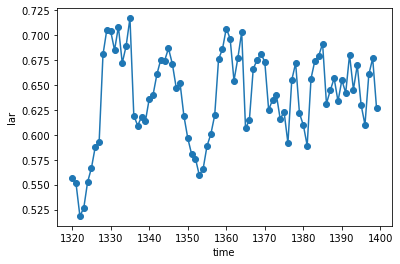

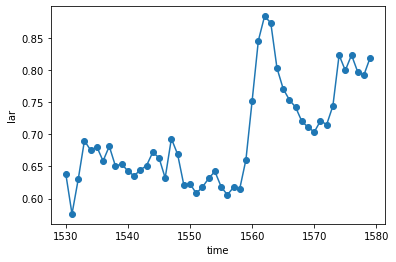

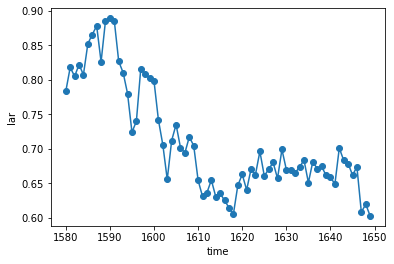

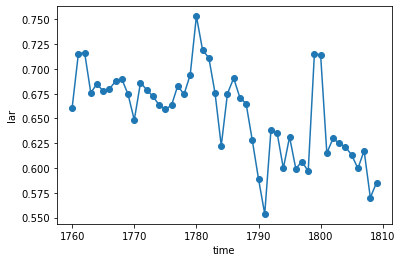

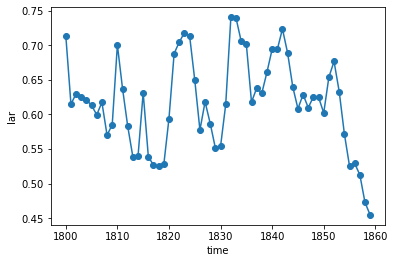

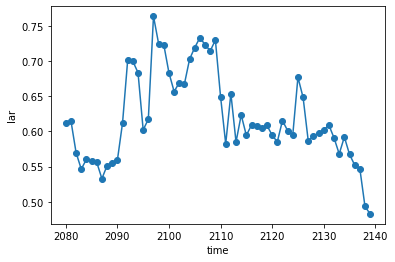

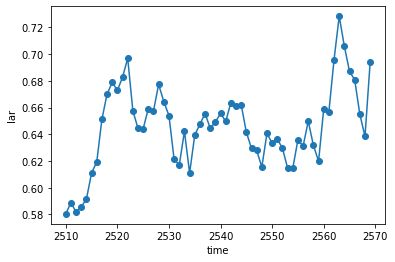

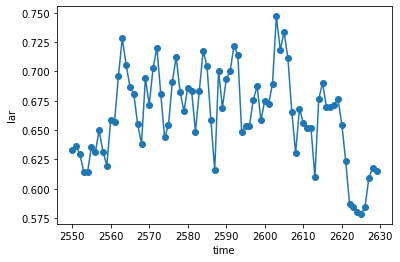

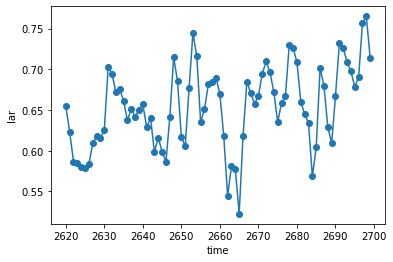

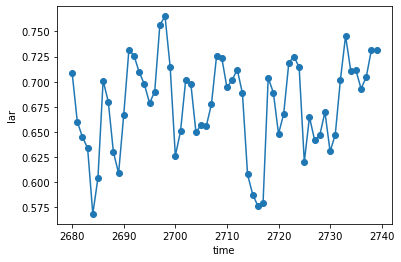

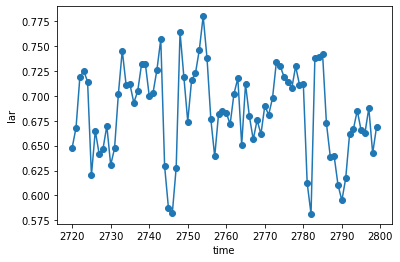

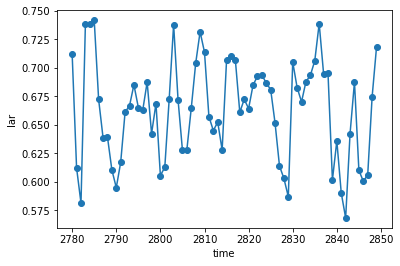

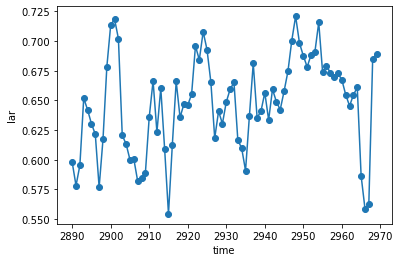

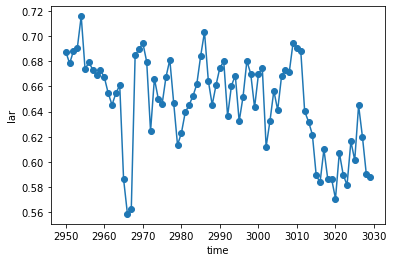

In [8]:
for (start, end) in duration:
    t = int(start - 1) * 1000
    LARs = []
    while t < int(end + 1)  * 1000:
        VC.set(cv2.CAP_PROP_POS_MSEC, t)
        rval, frame = VC.read()
        if rval:
            lar, frame = process_frame(frame)
            # plt.imshow(frame)
        else:
            lar = [0]
        LARs = LARs + lar
        t += 100
    
    x = np.arange(int(start - 1) * 10, int(end + 1) * 10)
    plt.plot(x, LARs,'o-')
    plt.xlabel('time')
    plt.ylabel('lar')
    plt.show()